In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tqdm import trange
import math
import cmath
import time
from scipy import constants

##drawModel1D

In [ ]:
#start = time.clock();
# Please check the Magnetic Permeability (H/m)
# at: https://docs.scipy.org/doc/scipy-0.14.0/reference/constants.html#module-scipy.constants
mu = constants.mu_0; #Magnetic Permeability (H/m)
def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistividad $(\Omega$m$)$', zlabel='Profundidad (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

#Forward VES

In [ ]:
@tf.function
def forward(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 25), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant(np.logspace(0.0, 0.9, 15), dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

@tf.function
def forward2(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 25), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant([5, 10, 15, 20], dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

#Forward MT

In [ ]:
@tf.function
def MTforwardModelTF(resistivities):
    frequencies =tf.cast(np.logspace(-3, 3, 31),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)
    n = len(resistivities)
    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()

@tf.function
def MTforwardModelTF2(layer_thicknesses_inv,resistivities):
    frequencies =tf.cast(np.logspace(-3, 3, 31),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)

    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    n = resistivities.shape[0]
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()

In [ ]:
print(np.logspace(0.6, 1.7, 20))

[ 3.98107171  4.54877795  5.19743987  5.93860187  6.78545457  7.75306963
  8.8586679  10.121926   11.56532642 13.2145577  15.09897161 17.2521055
 19.71227922 22.52327705 25.735127   29.40499112 33.59818286 38.38932945
 43.86370006 50.11872336]


#VES synthetic model

In [ ]:
synRES = tf.constant([500, 150, 80, 40, 150], dtype = tf.float64)
synTHK = tf.constant([5, 10, 15, 20], dtype = tf.float64)

tf.Tensor([ 5. 10. 15. 20.], shape=(4,), dtype=float64)


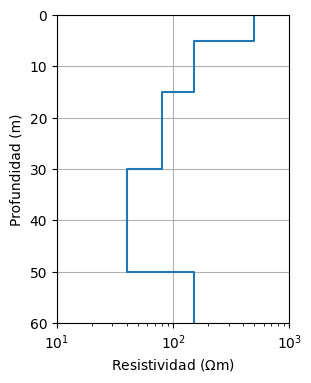

In [ ]:
fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, synTHK, synRES,plot='semilogx')
plt.xlim([10**1,10**3])
print(synTHK)

#MT synthetic model

[5, 10, 15, 20, 50, 100, 150]


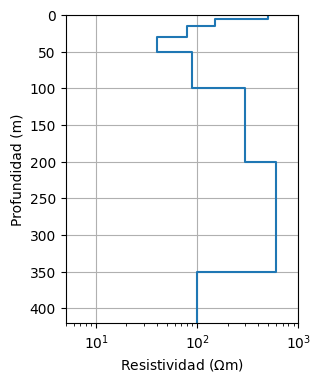

In [ ]:
#layer_tops = np.r_[0., -synTHK.numpy(), -50., -100., -200., -350.]  # in m
rho_layers = [500, 150, 80, 40, 90, 300, 600, 100]
layer_thicknesses = [5, 10, 15, 20, 50, 100, 150]

synthk,synres = layer_thicknesses,rho_layers
fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, layer_thicknesses, rho_layers,plot='semilogx')
plt.xlim([5.0,10**3])
print(layer_thicknesses)

synthk,synres = layer_thicknesses,rho_layers

In [ ]:
layer_thicknesses_inv = np.concatenate((np.logspace(0.0, 0.9, 15), np.logspace(0.8, 1.96, 9)))

In [ ]:
np.sum((np.logspace(-0.2, 0.5, 10)))

np.float64(16.068726595681216)

In [ ]:
np.sum(layer_thicknesses)

np.int64(350)

In [ ]:
np.sum(layer_thicknesses_inv)

np.float64(356.83829401111666)

#DLJIneT

In [ ]:
# RED PAUL GOYES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, concatenate, add

# Function to build the model
def build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly):
    # Define the two input layers: one for the VES data and another for the MT data
    input_layer1 = Input(shape=(input_dim_ves,))  # Input layer for the VES data
    input_layer2 = Input(shape=(input_dim_mt,))   # Input layer for the MT data

    # Concatenate the two input layers into a single layer
    concatenated_inputs = concatenate([input_layer1, input_layer2])

    # First dense layer with ReLU activation
    previous_layer = Dense(nc, activation='relu')(concatenated_inputs)

    # Create hidden layers with residual connections
    for _ in range(ly):
        # Create a dense hidden layer with L1 regularization
        hidden_layer = Dense(nc, activation='relu', kernel_regularizer='l1')(previous_layer)
        # Add the previous layer to the hidden layer (residual connection)
        previous_layer = add([previous_layer, hidden_layer])

    # Output layer with sigmoid activation
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)

    # Create the model with the specified inputs and output
    model = keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)

    return model

# Define the dimensions of the inputs and output
input_dim_ves = 25  # Dimension of the VES input
input_dim_mt = 31   # Dimension of the MT input
output_dim = 25     # Dimension of the output
nc = 128*2          # Number of neurons in each layer
ly = 2              # Number of hidden layers

# Build the model
DLJIneT = build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly)
DLJIneT.summary()  # Optional: uncomment this line to print the model summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56)        │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     14,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      6,425 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 152,601 (596.10 KB)

 Trainable params: 152,601 (596.10 KB)

 Non-trainable params: 0 (0.00 B)

#VES data

In [ ]:
d_obs = forward2(synres[:5])

synthetic_data_log = tf.cast(tf.math.log(d_obs) / tf.math.log(tf.constant(10.0, dtype=tf.float64)), dtype=tf.float64)

d_obs_scaled = tf.constant(synthetic_data_log, dtype=tf.float64)
d_obs_scaled = tf.reshape(d_obs_scaled, (1, len(synthetic_data_log)))

In [ ]:
d_obs_scaled.shape

TensorShape([1, 25])

#MT data

In [ ]:
z_obs = MTforwardModelTF2(synthk, synres)

z_obs = tf.constant(z_obs, dtype=tf.complex128)

z_obs_scaled = tf.reshape(z_obs, (1, len(z_obs)))

#Training algorithm

In [ ]:
from tqdm import trange

# List of alpha values
alpha_values = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Dictionary to store losses and predictions
losses = {}
losses_VES = {}
losses_MT = {}
losses_reg = {}
loss_evolution = {}
all_d_pred_VES = {}
all_d_pred_MT = {}
all_model_pred = {}

# Number of training iterations
num_iterations = 300

for alpha in alpha_values:
    # Build the model
    DLJIneT = build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

    @tf.function
    def train():
        with tf.GradientTape() as tape:
            model_pred = tf.squeeze(DLJIneT([d_obs_scaled, tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64)], training=True))
            scaled_model_pred = 10 ** (3 * model_pred)
            d_pred = forward(scaled_model_pred[:16])
            log_d_pred = tf.math.log(d_pred) / tf.math.log(tf.constant(10.0, dtype=tf.float64))

            diff = tf.math.subtract(model_pred[1:], model_pred[:-1])
            diff = tf.cast(diff, dtype=tf.float64)
            logspace_tensor = tf.constant(layer_thicknesses_inv, dtype=tf.float64)
            loss_diff = tf.norm(diff / logspace_tensor, 2)

            loss_VES = (0.5) * tf.norm(d_obs_scaled - log_d_pred, ord=2)
            res_pred = 10 ** (3 * DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=True))
            loss_MT = tf.math.real(0.5*tf.norm(tf.math.log(z_obs_scaled) - tf.math.log(MTforwardModelTF(tf.reshape(res_pred, (-1,)))), 2))

            loss = (alpha) * loss_VES + (1 - alpha) * loss_MT + loss_diff

        grads = tape.gradient(loss, DLJIneT.trainable_weights)
        optimizer.apply_gradients(zip(grads, DLJIneT.trainable_weights))
        return loss, loss_VES, loss_MT, loss_diff

    final_loss, final_loss_VES, final_loss_MT, final_loss_reg = None, None, None, None
    loss_evolution[alpha] = []

    for i in trange(num_iterations, desc=f"Training alpha={alpha}"):
        los = train()
        final_loss, final_loss_VES, final_loss_MT, final_loss_reg = los[0].numpy(), los[1].numpy(), los[2].numpy(), los[3].numpy()
        loss_evolution[alpha].append(final_loss)  # Store loss evolution

    # Store final loss values
    losses[alpha] = final_loss
    losses_VES[alpha] = final_loss_VES
    losses_MT[alpha] = final_loss_MT
    losses_reg[alpha] = final_loss_reg

    # Print final loss values for this alpha
    print(f"Final Loss Values for Alpha {alpha}:")
    print(f"Total Loss: {final_loss:.6f}")
    print(f"VES Loss: {final_loss_VES:.6f}")
    print(f"MT Loss: {final_loss_MT:.6f}")
    print(f"Regularization Loss: {final_loss_reg:.6f}\n")

    model_pred = 10 ** (3 * tf.squeeze(DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=False)))
    all_d_pred_VES[alpha] = forward(model_pred[:16]).numpy()
    all_d_pred_MT[alpha] = MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(model_pred, (-1,))).numpy()
    all_model_pred[alpha] = model_pred.numpy()

Training alpha=0.0: 100%|██████████| 300/300 [00:55<00:00,  5.36it/s]


Final Loss Values for Alpha 0.0:
Total Loss: 0.021410
VES Loss: 1.164131
MT Loss: 0.015309
Regularization Loss: 0.006101



Training alpha=0.2: 100%|██████████| 300/300 [00:46<00:00,  6.43it/s]


Final Loss Values for Alpha 0.2:
Total Loss: 0.088074
VES Loss: 0.030352
MT Loss: 0.034562
Regularization Loss: 0.054354



Training alpha=0.3: 100%|██████████| 300/300 [00:46<00:00,  6.48it/s]


Final Loss Values for Alpha 0.3:
Total Loss: 0.082286
VES Loss: 0.021641
MT Loss: 0.027872
Regularization Loss: 0.056283



Training alpha=0.4: 100%|██████████| 300/300 [00:46<00:00,  6.47it/s]


Final Loss Values for Alpha 0.4:
Total Loss: 0.082502
VES Loss: 0.016366
MT Loss: 0.029543
Regularization Loss: 0.058229



Training alpha=0.5: 100%|██████████| 300/300 [00:46<00:00,  6.48it/s]


Final Loss Values for Alpha 0.5:
Total Loss: 0.081955
VES Loss: 0.014254
MT Loss: 0.030832
Regularization Loss: 0.059412



Training alpha=0.6: 100%|██████████| 300/300 [00:46<00:00,  6.41it/s]


Final Loss Values for Alpha 0.6:
Total Loss: 0.073995
VES Loss: 0.011693
MT Loss: 0.015757
Regularization Loss: 0.060677



Training alpha=0.7: 100%|██████████| 300/300 [00:46<00:00,  6.49it/s]


Final Loss Values for Alpha 0.7:
Total Loss: 0.075478
VES Loss: 0.010900
MT Loss: 0.021564
Regularization Loss: 0.061379



Training alpha=0.8: 100%|██████████| 300/300 [00:46<00:00,  6.51it/s]


Final Loss Values for Alpha 0.8:
Total Loss: 0.080317
VES Loss: 0.008659
MT Loss: 0.053491
Regularization Loss: 0.062692



Training alpha=0.9: 100%|██████████| 300/300 [00:46<00:00,  6.52it/s]


Final Loss Values for Alpha 0.9:
Total Loss: 0.077370
VES Loss: 0.007923
MT Loss: 0.069299
Regularization Loss: 0.063309



Training alpha=1.0: 100%|██████████| 300/300 [00:46<00:00,  6.51it/s]

Final Loss Values for Alpha 1.0:
Total Loss: 0.071342
VES Loss: 0.008055
MT Loss: 0.441993
Regularization Loss: 0.063287



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

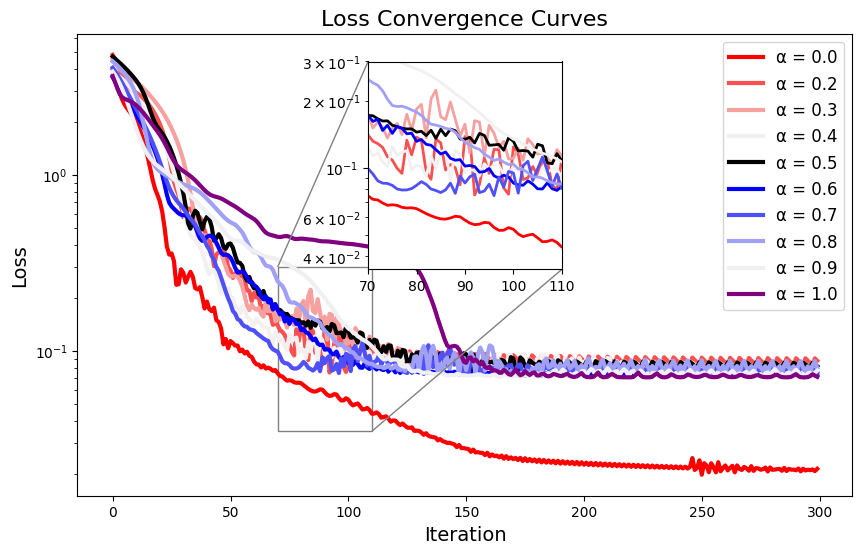

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

# Custom palettes
red_shades = sns.light_palette("red", n_colors=4, reverse=True)     # Reds (dark to light)
blue_shades = sns.light_palette("blue", n_colors=4, reverse=True)   # Blues (dark to mid tones, NOT very light)
black = [(0, 0, 0)]                                                  # Black
purple = [(0.5, 0, 0.5)]                                             # Purple (manual RGB)

# Combine colors
colors = red_shades + black + blue_shades + purple  # Total: 10 colors

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot curves
for i, alpha in enumerate(alpha_values):
    ax.plot(range(num_iterations), loss_evolution[alpha], label=f'α = {alpha}',
            color=colors[i], linewidth=3)

# Main plot aesthetics
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.set_title('Loss Convergence Curves', fontsize=16)
ax.set_yscale('log')
ax.legend(fontsize=12, loc='best')
ax.grid(False)

# Create zoomed inset
axins = inset_axes(ax, width="25%", height="45%", loc='upper center', borderpad=2)

# Plot inside the zoomed inset
for i, alpha in enumerate(alpha_values):
    axins.plot(range(num_iterations), loss_evolution[alpha], color=colors[i], linewidth=2)

# Set zoomed view limits
axins.set_xlim(70, 110)
axins.set_ylim(0.035, 0.3)
axins.set_yscale('log')

# Make tick labels visible (optional)
axins.tick_params(labelleft=True, labelbottom=True)

# Connect main plot and zoomed region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Save figure
plt.savefig('convergence_curves.svg', format='svg')

# Code to download the file (for environments like Google Colab)
from google.colab import files
#files.download('convergence_curves.svg')

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


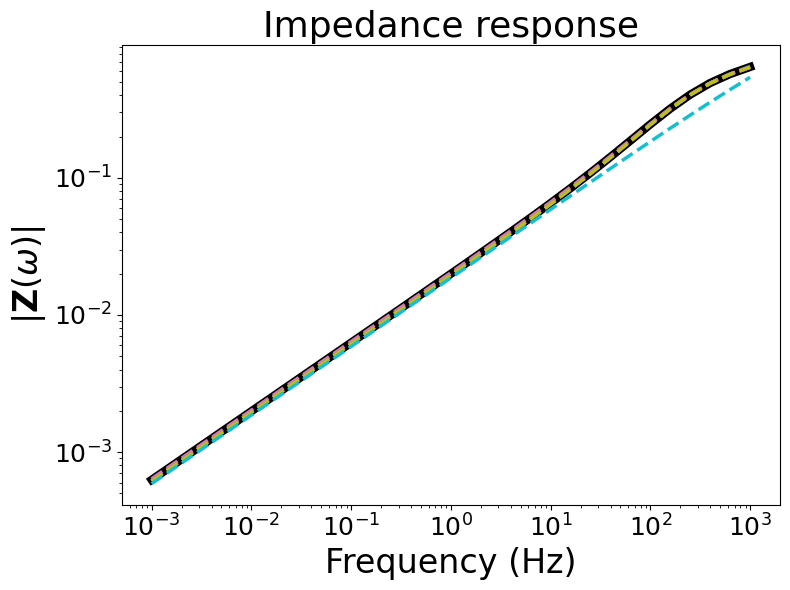

In [ ]:
# Plot the impedance for all alphas
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.loglog(np.logspace(-3, 3, 31), z_obs, 'k', label='Observed', linewidth=6)
for alpha in alpha_values:
    ax.loglog(np.logspace(-3, 3, 31), all_d_pred_MT[alpha], '--', label=f'Alpha {alpha}', linewidth=2.5)
ax.set_ylabel("$|\\mathbf{Z}(\\omega)|$", fontsize=24)
ax.set_xlabel("Frequency (Hz)", fontsize=24)
ax.tick_params(axis='both', labelsize=18)
plt.title('Impedance response', fontsize=26)
#plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('impedance_response_all_alphas.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

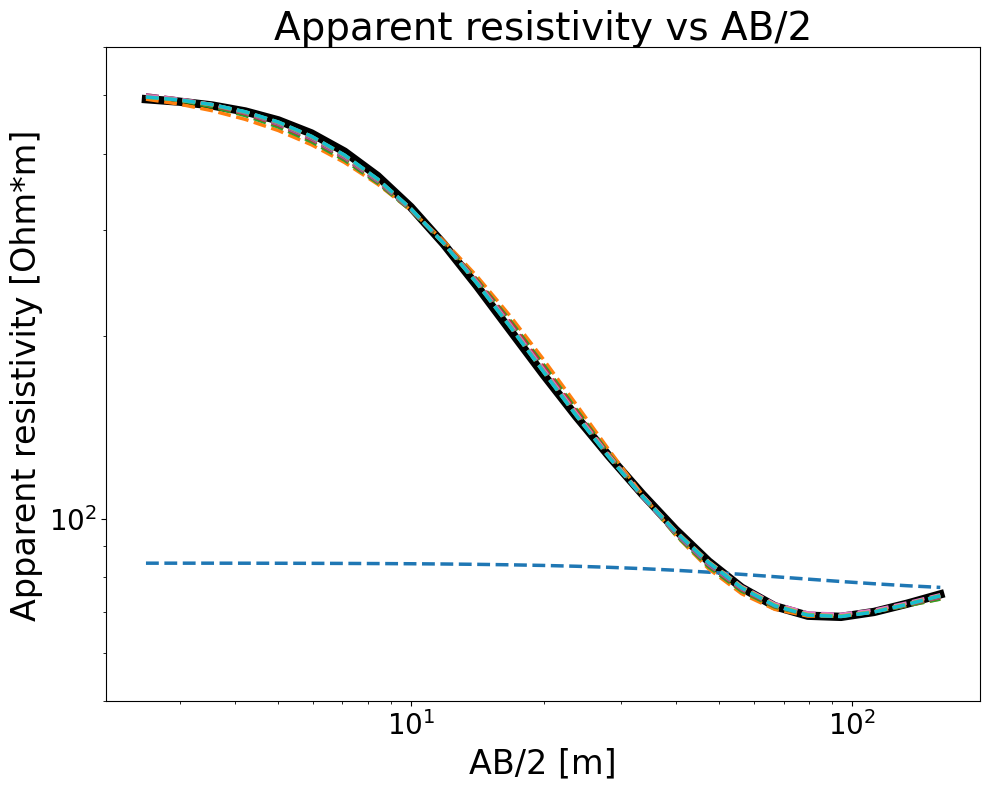

In [ ]:
# Plot the apparent resistivity for all alphas
ab2 = tf.cast(np.logspace(0.4, 2.2, 25), dtype=tf.float64)
fig, ax_main = plt.subplots(figsize=(10, 8))
ax_main.plot(ab2, d_obs, linestyle='-', label='Observed', color='black', linewidth=6)
for alpha in alpha_values:
    ax_main.plot(ab2, all_d_pred_VES[alpha], linestyle='--', label=f'Alpha {alpha}', linewidth=2.5)
ax_main.set_ylim(50, 600)
ax_main.set_yscale('log')
ax_main.set_xscale('log')
ax_main.set_xlabel('AB/2 [m]', fontsize=24)
ax_main.set_ylabel('Apparent resistivity [Ohm*m]', fontsize=24)
ax_main.set_title('Apparent resistivity vs AB/2', fontsize=28)
ax_main.tick_params(axis='both', which='major', labelsize=20)
#plt.legend(fontsize=20, loc='lower right')
ax_main.grid(False)
plt.tight_layout()
plt.savefig('apparent_resistivity_vs_ab2_all_alphas.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Total number of models: 10
Predictions for Alpha = 0.0: [ 84.33734   84.488556  84.30061   84.35716   84.253815  84.21735
  83.88169   83.588455  83.418434  82.50079   81.56562   80.36593
  78.76438   77.253044  75.9265    75.38427   75.91902   78.384056
  87.45843  115.666954 194.6389   380.05618  608.7458   583.93445
  98.76876 ]


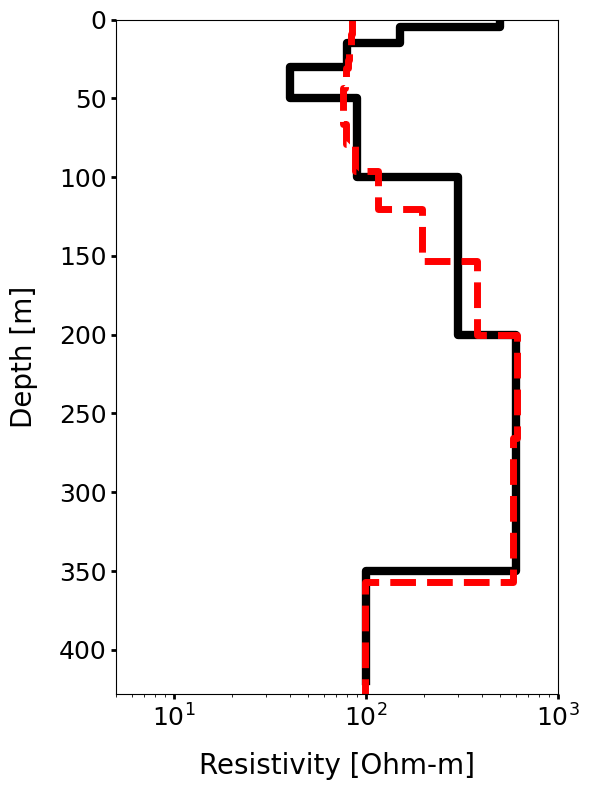

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.2: [516.43005  497.45712  439.21442  356.1828   272.64148  204.37192
 154.8476   120.10913   97.86003   80.67064   67.68092   56.65045
  49.23234   47.306187  55.290634  82.99711   73.28773   70.59326
  92.29405  164.86638  274.2748   493.96265  350.0283   830.05383
  97.11724 ]


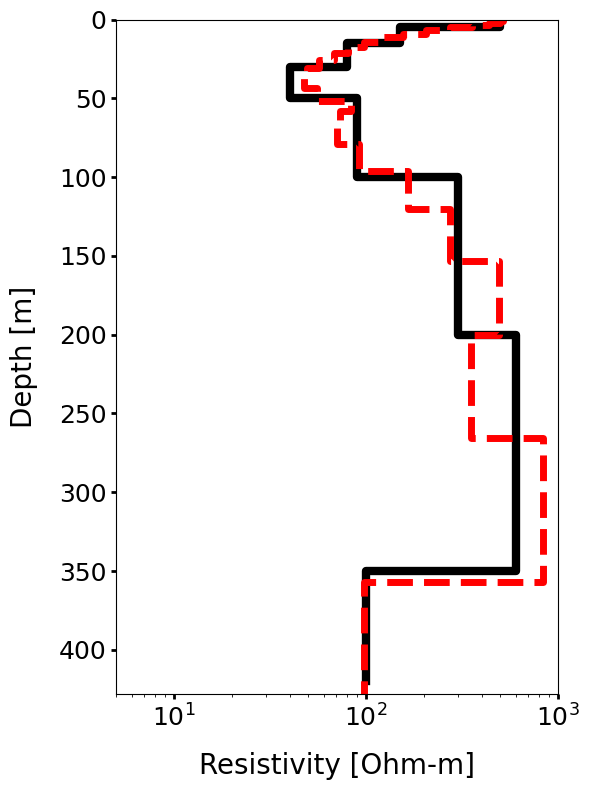

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.3: [521.29346  507.1231   449.8985   357.84854  265.91608  194.58046
 147.08438  116.923706  97.85544   84.29999   71.38703   59.969345
  50.003193  45.8161    52.487072  83.13063   73.49135   71.437584
  91.96091  156.29425  246.75356  404.3371   947.0829   460.9847
  97.77674 ]


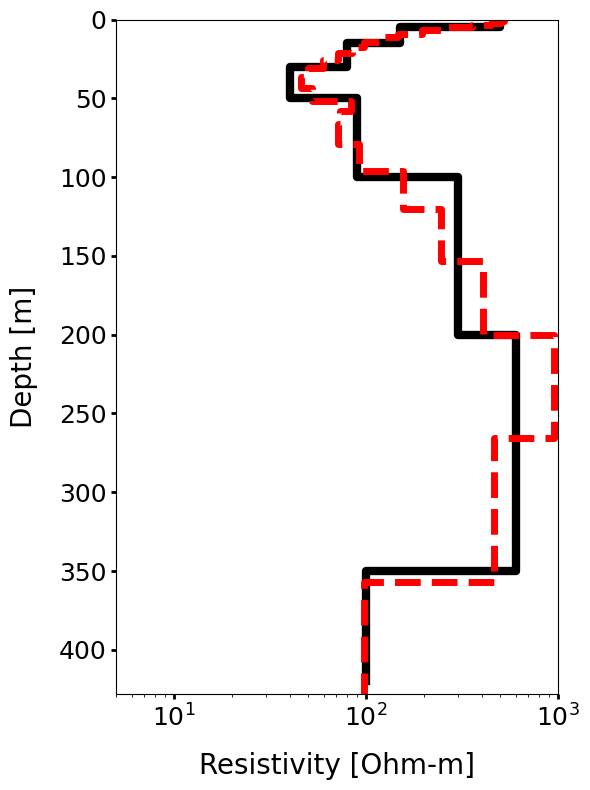

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.4: [518.90845  511.5668   459.56842  361.32642  262.4051   188.37787
 141.67479  114.441925  98.90112   87.988144  76.246414  62.432022
  49.36727   42.640568  48.462757  85.28196   74.708855  74.0804
  90.96952  166.8088   322.5451   390.97824  524.74817  495.28232
  97.65138 ]


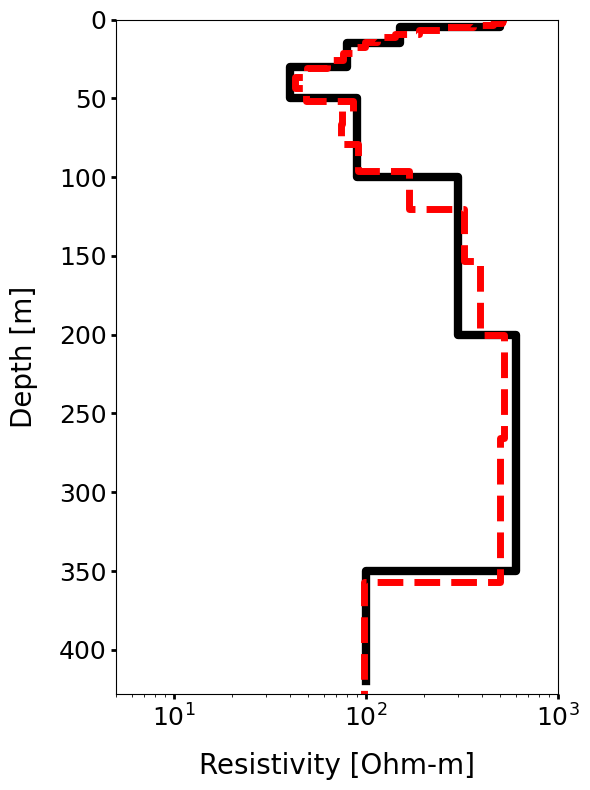

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.5: [515.6861   514.91296  463.70792  362.6957   259.00513  184.03389
 137.87524  113.981895  99.43274   89.87394   77.18691   62.721725
  49.096554  42.27827   48.5786    85.54323   76.48704   74.34546
  93.10596  165.72754  335.242    433.56952  314.90265  918.9636
  97.52837 ]


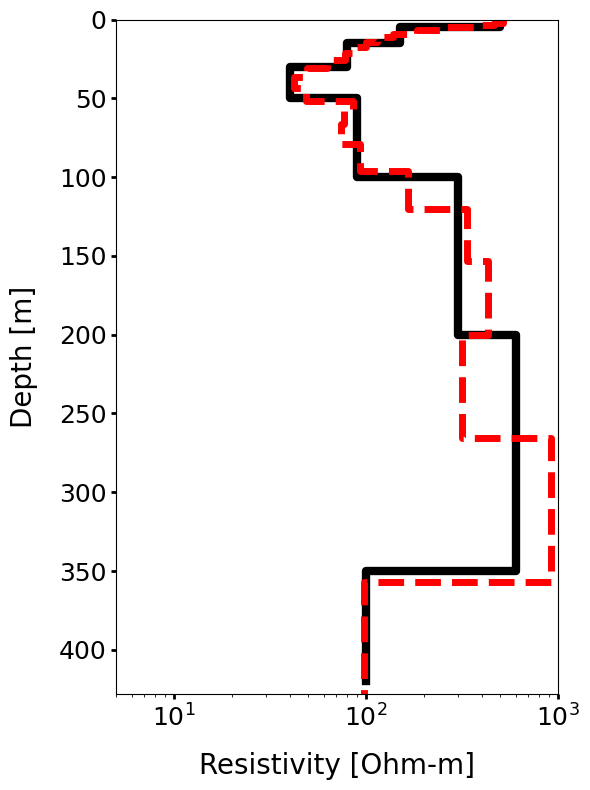

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.6: [511.4194   516.4689   470.87274  364.99536  255.8048   179.8038
 135.40605  112.72409  101.4412    92.79937   80.42695   63.65493
  48.066364  40.237892  46.695705  86.76951   78.52453   76.517235
  94.60513  158.1456   281.61313  410.54352  864.2176   414.95135
  98.65125 ]


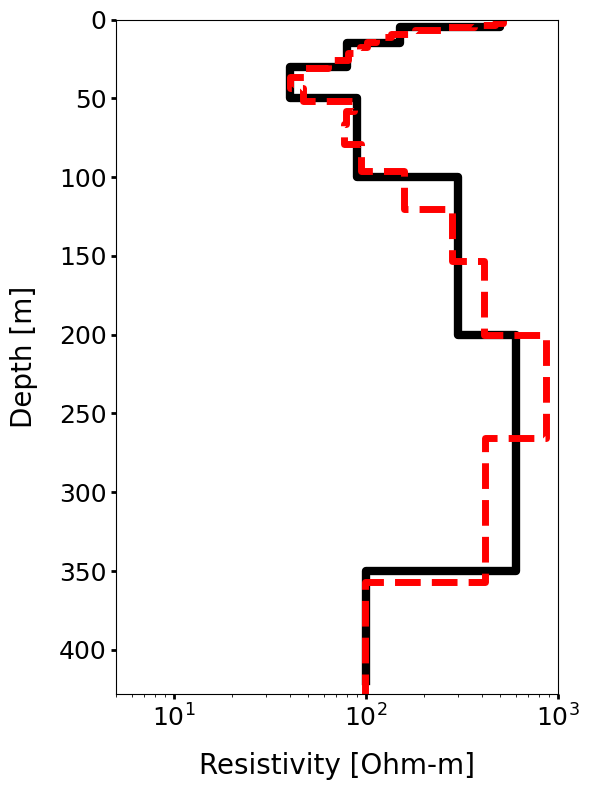

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.7: [508.72812  517.7446   474.22754  365.67807  254.89641  178.02583
 134.66702  113.25462  102.809555  94.53692   81.015884  63.84742
  48.019638  40.229855  46.385048  87.70761   80.67846   78.62838
  93.90071  157.65054  329.6621   443.2679   477.72476  469.1527
 103.42909 ]


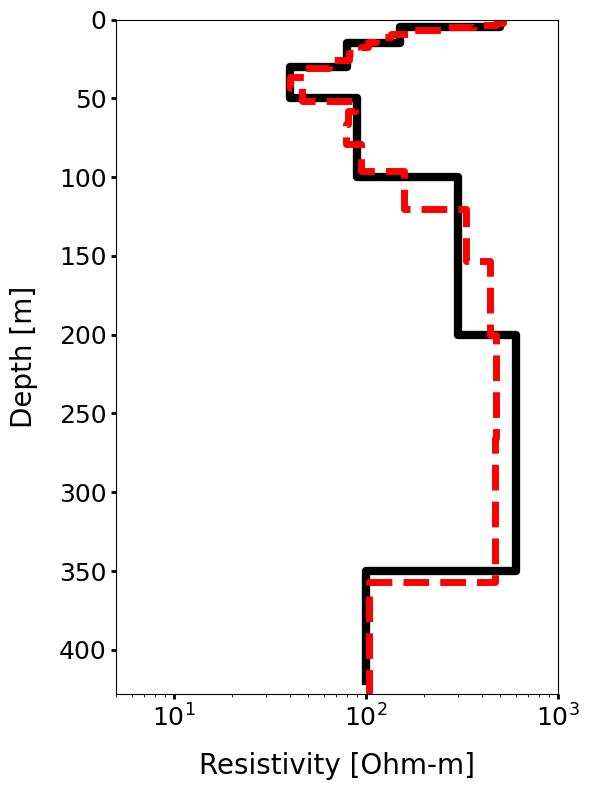

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.8: [503.06754  517.9408   481.14688  367.03824  251.54984  173.82408
 131.28052  112.85362  104.8425    95.521545  81.896454  62.81756
  46.766758  38.882557  45.612286  88.0879    85.84323   88.028076
 103.426765 151.5141   266.25177  364.3167   402.82495  643.9225
  96.6782  ]


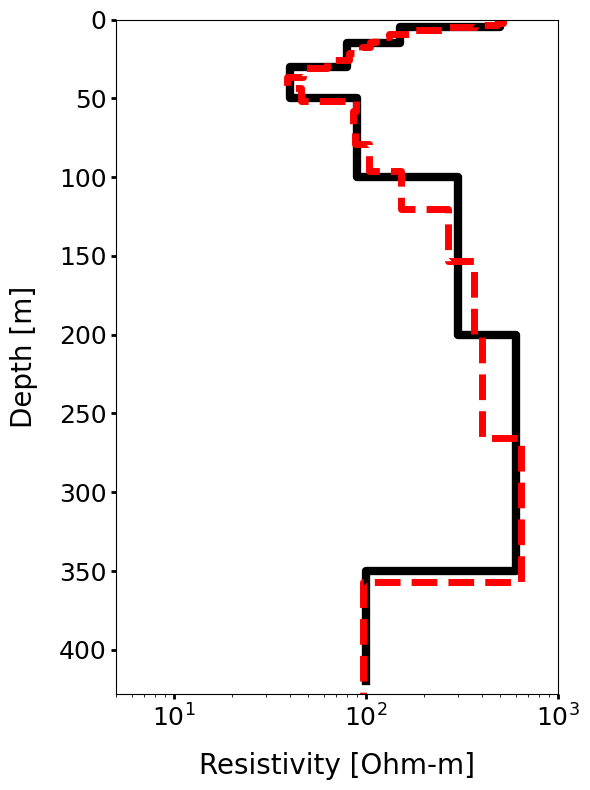

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 0.9: [500.7841   519.52014  483.7435   367.5131   249.25897  172.22054
 130.70882  112.49683  105.96088   96.61854   82.214035  63.237072
  46.59172   38.91133   45.374996  88.19179   87.434235  91.54179
 105.71945  143.78882  235.26237  386.8198   467.22733  643.2392
  95.94017 ]


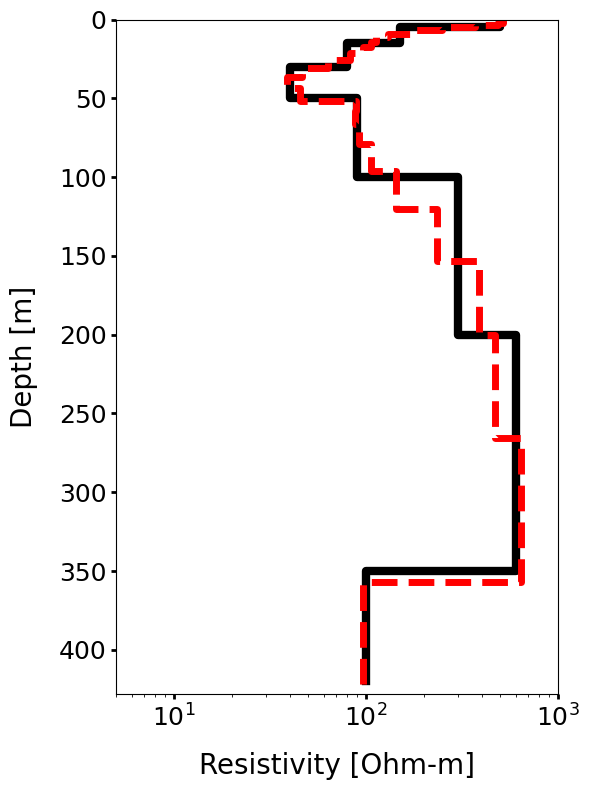

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions for Alpha = 1.0: [500.83496  519.8103   484.36398  368.1427   249.16278  171.24307
 130.63565  113.02481  105.49033   97.173134  81.86641   62.477264
  46.278614  38.82063   45.503937  88.2361    88.384346  88.26022
  88.16417   88.1474    88.22321   88.15089   88.04214   87.96655
  87.93416 ]


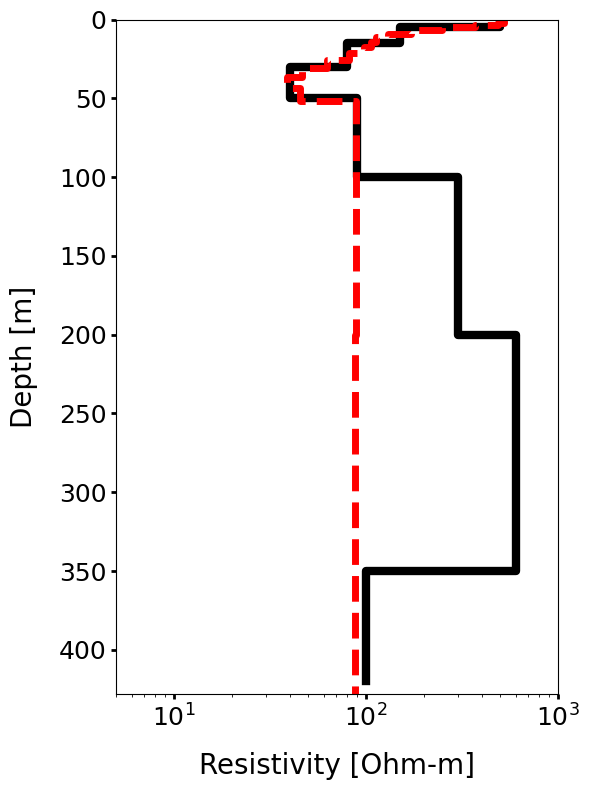

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Ensure that predictions are available
print(f"Total number of models: {len(all_model_pred)}")

# List of alpha values used in training
alpha_values = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Loop over each trained model corresponding to an alpha value
for i, alpha in enumerate(alpha_values):
    # Create a new figure for each alpha
    fig, ax = plt.subplots(figsize=(6, 8))  # Slightly larger for better clarity

    # Plot the true model (you should have your real data here)
    drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=6.0)  # Black line with thicker width

    # Get the model predictions for the current alpha
    model_pred = all_model_pred[alpha]  # Get the corresponding model prediction

    # If the model is in TensorFlow tensor format, convert it to numpy
    if isinstance(model_pred, tf.Tensor):
        model_pred = model_pred.numpy()

    # Check if predictions are correct
    print(f"Predictions for Alpha = {alpha}: {model_pred}")

    # Plot the predicted model with a red dashed line
    drawModel1D(ax, layer_thicknesses_inv, model_pred, linestyle='--',
                label=f'Predicted (Alpha = {alpha})', color='red', linewidth=5.0)

    # Configure the plot
    ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
    ax.set_xlabel('Resistivity [Ohm-m]', fontsize=20, labelpad=15)  # x-axis label with extra padding
    ax.set_ylabel('Depth [m]', fontsize=20, labelpad=15)  # y-axis label with extra padding
    ax.tick_params(axis='both', which='major', labelsize=18, width=2)  # Increase label size and line width

    # Limit the values on the x-axis
    plt.xlim([5, 10**3])

    # Add subtle gridlines for better readability
    ax.grid(False)

    # Improve margins and layout
    plt.tight_layout()

    # Save the plot with a unique filename for each alpha
    filename = f'alpha_{alpha:.1f}.svg'
    plt.savefig(filename, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

    # Code to download the file (if used in an environment like Google Colab)
    from google.colab import files
    #files.download(filename)


In [ ]:
# Function to compute RMSE in percentage
def compute_rmspe(y_true, y_pred):
    y_pred = np.reshape(y_pred, (-1))
    y_true = np.reshape(y_true, (-1))

    if len(y_true) != len(y_pred):
        raise ValueError("Data lists must be the same length")

    percentage_errors = (y_true - y_pred) / y_true
    rmspe = np.sqrt(np.mean(percentage_errors ** 2)) * 100
    return rmspe

# Compute RMSE % for each alpha and print total
for alpha in alpha_values:
    pred_VES = all_d_pred_VES.get(alpha)
    pred_MT = all_d_pred_MT.get(alpha)

    if pred_VES is not None and pred_MT is not None:
        rmse_ves = compute_rmspe(d_obs, pred_VES)  # VES vs VES
        rmse_mt = compute_rmspe(np.abs(z_obs), np.abs(pred_MT))  # MT vs MT
        total_rmspe = rmse_ves + rmse_mt

        print(f"Alpha {alpha}: RMSPE VES = {rmse_ves:.2f}%, RMSPE MT = {rmse_mt:.2f}%, Total RMSPE = {total_rmspe:.2f}%")
    else:
        print(f"Warning: Missing predictions for alpha {alpha}")

Alpha 0.0: RMSPE VES = 55.90%, RMSPE MT = 0.51%, Total RMSPE = 56.41%
Alpha 0.2: RMSPE VES = 2.86%, RMSPE MT = 1.08%, Total RMSPE = 3.93%
Alpha 0.3: RMSPE VES = 1.99%, RMSPE MT = 0.83%, Total RMSPE = 2.82%
Alpha 0.4: RMSPE VES = 1.54%, RMSPE MT = 0.90%, Total RMSPE = 2.44%
Alpha 0.5: RMSPE VES = 1.30%, RMSPE MT = 0.92%, Total RMSPE = 2.22%
Alpha 0.6: RMSPE VES = 1.07%, RMSPE MT = 0.50%, Total RMSPE = 1.57%
Alpha 0.7: RMSPE VES = 1.05%, RMSPE MT = 1.36%, Total RMSPE = 2.41%
Alpha 0.8: RMSPE VES = 0.79%, RMSPE MT = 1.29%, Total RMSPE = 2.08%
Alpha 0.9: RMSPE VES = 0.71%, RMSPE MT = 1.56%, Total RMSPE = 2.27%
Alpha 1.0: RMSPE VES = 0.70%, RMSPE MT = 13.19%, Total RMSPE = 13.89%


In [ ]:
# Install required libraries
!pip install -q pandas openpyxl

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd

# Output file path in your Google Drive
output_path = '/content/drive/MyDrive/loss_evolution.xlsx'

# Save to an Excel file with one sheet per alpha
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    for i, alpha in enumerate(alpha_values):
        # Get loss values for this alpha
        losses = loss_evolution[alpha]

        # Create DataFrame: one column, rows = steps
        df = pd.DataFrame(losses, columns=['Loss'])

        # Valid sheet name for Excel (max 31 characters)
        sheet_name = f"alpha_{alpha:.4f}"[:31]

        # Save sheet
        df.to_excel(writer, sheet_name=sheet_name, index_label='Step')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
